In [76]:
import pandas as pd
import string
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer

### initial data treatment
transforming into pandas dataframe, removing upper case letters and punctuation, visualizing distribution

In [2]:
from datasets import load_dataset

dataset = load_dataset("QuotaClimat/frugalaichallenge-text-train")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['quote', 'label', 'source', 'url', 'language', 'subsource', 'id', '__index_level_0__'],
        num_rows: 6091
    })
})


In [14]:
print(next(iter(dataset['train'])))

{'quote': 'There is clear, compelling evidence that many of the major conclusions of the IPCC, your new religions constantly-changing Holy Book, are based on evidence that has been fabricated. The hockey stick graph that purported to abolish the mediaeval warm period is just one example.', 'label': '5_science_unreliable', 'source': 'FLICC', 'url': 'https://huggingface.co/datasets/fzanartu/FLICCdataset', 'language': 'en', 'subsource': 'CARDS', 'id': None, '__index_level_0__': 0}


In [115]:
df = pd.DataFrame(dataset['train'])

In [20]:
df.head()

,quote,label,source,url,language,subsource,id,__index_level_0__
0,"There is clear, compelling evidence that many ...",5_science_unreliable,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,0
1,"For most of the Holocene (last 10k years), sea...",1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test1,None,1
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,2
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,3
4,It's going to be 42 here today and the hottest...,1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test3,None,4


<AxesSubplot:xlabel='label'>

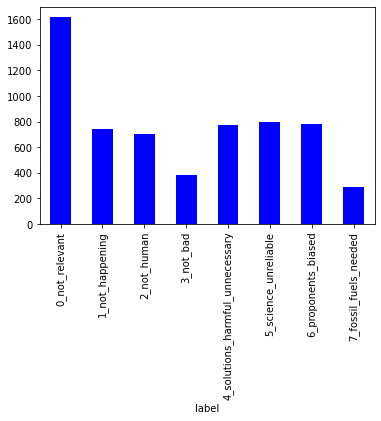

In [90]:
df.groupby('label').quote.count().plot.bar(color = 'blue')

In [91]:
df['quote'] = df['quote'].str.replace(f"[{string.punctuation}]", "", regex=True).str.lower()

### data pre-processing
removing stopwords

In [92]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rudyferreira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [116]:
stopwords_set = set(stopwords)
important_stopwords = {'not', 'never'}
stopwords_set = stopwords_set - important_stopwords

def stop_word(sentence):
    return " ".join([word for word in sentence.split() if word.lower() not in stopwords_set])

In [117]:
nltk.download('wordnet')

def lemmatize(sentence):
    return " ".join([lemmatizer.lemmatize(word) for word in sentence.split()])

df['quote'] = df['quote'].apply(lemmatize)
df.head(10)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rudyferreira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,quote,label,source,url,language,subsource,id,__index_level_0__
0,"There is clear, compelling evidence that many ...",5_science_unreliable,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,0
1,"For most of the Holocene (last 10k years), sea...",1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test1,None,1
2,"China, which host U.N. climate talk next week ...",4_solutions_harmful_unnecessary,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,2
3,And the fabricated document (which Dr. Mann ap...,0_not_relevant,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,3
4,It's going to be 42 here today and the hottest...,1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test3,None,4
5,The global warming crisis emerged from a belie...,5_science_unreliable,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,5
6,Donald Trump ha called climate change a fabric...,6_proponents_biased,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,jindev,None,6
7,"It is significantly colder globally, colder ev...",1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,7
8,Another issue wa the move of weather station f...,5_science_unreliable,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test3,None,8
9,Many of these fear monger also say we should s...,7_fossil_fuels_needed,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,jintrain,None,9


In [114]:
stemmer = SnowballStemmer('english')
def stem(sentence):
    new_sentence = []
    for word in sentence.split():
        word = stemmer.stem(word)
        new_sentence.append(word)
    return (" ".join(new_sentence))

df['quote'] = df['quote'].apply(stem)

In [54]:
df.head(10)

,quote,label,source,url,language,subsource,id,__index_level_0__
0,clear compel evid mani major conclus ipcc new ...,5_science_unreliable,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,0
1,holocen last 10k year sea level rise rate arou...,1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test1,None,1
2,china host un climat talk next week first time...,4_solutions_harmful_unnecessary,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,2
3,fabric document dr mann appar still think fact...,0_not_relevant,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,3
4,go 42 today hottest summer record iirc 1934 su...,1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test3,None,4
5,global warm crisi emerg belief small rise co 2...,5_science_unreliable,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,5
6,donald trump call climat chang fabric part chi...,6_proponents_biased,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,jindev,None,6
7,signific colder global colder even signific dr...,1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,7
8,anoth issu move weather station suburban urban...,5_science_unreliable,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test3,None,8
9,mani fear monger also say stop burn fossil fue...,7_fossil_fuels_needed,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,jintrain,None,9


### feature extraction

In [118]:
Tfidf = TfidfVectorizer(min_df = 2, max_features = 10000, ngram_range = (1,2), sublinear_tf = True, stop_words = 'english')
tfidf_features = Tfidf.fit_transform(df['quote'])
tfidf_features.shape

(6091, 10000)

In [119]:
N = 500  
chi2_scores, _ = chi2(tfidf_features, df['label'])
indices = np.argsort(chi2_scores)[::-1]
selected_features = indices[:N]

tfidf_features = tfidf_features[:, selected_features]

### model training

In [138]:
from sklearn.linear_model import LogisticRegression

LRClass = LogisticRegression(class_weight='balanced', random_state=42)
LRClass.fit(X_train, y_train)
prediction = LRClass.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, prediction))


Logistic Regression Accuracy: 0.6021328958162429


In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
RFClass = RandomForestClassifier(n_estimators=500, criterion="gini", random_state=77)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, df['label'], test_size = 1/5, random_state = 50)
RFClass.fit(X_train,y_train)
prediction = RFClass.predict(X_test)
print("accuracy score:")
print(accuracy_score(y_test, prediction))

accuracy score:
0.55701394585726


In [ ]:
from sklearn.linear_model import SGDClassifier
SGDC = SGDClassifier()
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, df['label'], test_size = 1/5, random_state = 50)
SGDC.fit(X_train, y_train)
prediction = SGDC.predict(X_test)
print(“accuracy score:”)
print(accuracy_score(y_test, prediction))

In [137]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, prediction))

print("\nClassification Report:")
print(classification_report(y_test, prediction))

print("\nF1-Score (weighted):", f1_score(y_test, prediction, average='weighted'))

Confusion Matrix:
[[220  13  12   2  23  13  23   4]
 [ 15  80  17   1   0  14   9   2]
 [  9  11  88   6   6  21   7   0]
 [ 14   7  14  34   4  10   8   0]
 [ 32   2   7   3  76   1  11   7]
 [ 29  11  20   1   5  89  18   0]
 [ 43  18   5   1  16  16  59   0]
 [ 10   1   2   1  15   0   0  33]]

Classification Report:
                                 precision    recall  f1-score   support

                 0_not_relevant       0.59      0.71      0.65       310
                1_not_happening       0.56      0.58      0.57       138
                    2_not_human       0.53      0.59      0.56       148
                      3_not_bad       0.69      0.37      0.49        91
4_solutions_harmful_unnecessary       0.52      0.55      0.54       139
           5_science_unreliable       0.54      0.51      0.53       173
            6_proponents_biased       0.44      0.37      0.40       158
          7_fossil_fuels_needed       0.72      0.53      0.61        62

                  